#### Introduction 
Anomia, impairment of the ability to access and retrieve words, is the hallmark deficit of people with aphasia (Goodglass & Wingfield, 1997). Prevailing cognitive models support the assumption that word retrieval involves semantic, lexical, and phonological processing (Dell, Schwartz, Martin, Saffran, & Gagnon, 1997; Foygel & Dell, 2000; Walker & Hickok, 2016). Confrontation picture naming tests (e.g., Druks & Masterson, 2000; German, 1990; Kaplan, Goodlgass, & Weintraub, 2001) are typically administered to assess anomia severity, build patients’ profiles, and quantify change after treatment. The Philadelphia Naming Test (PNT) (Roach, Schwartz, Martin, Grewal, & Brecher, 1996) is a confrontation naming test that was developed in tandem with a series of computational models of word retrieval in persons with aphasia (Dell & O’Seaghdha, 1992; Dell et al., 1997; Foygel & Dell, 2000). It is made up of diverse stimuli varying in length, age of acquisition, and lexical frequency (Francis & Kucera, 1982), it has a well-defined scoring system for classifying anomic errors (Dell et al., 1997), and its total score correlates highly with aphasia severity (Walker & Schwartz, 2012).
<br>
<br>
One of the computational models that was developed along with the PNT was Foygel & Dell’s (Foygel & Dell, 2000) semantic-phonological interactive two-step model (SP model). This model is organized into a conceptual semantic input layer, a phonological output layer, with a lexical layer situated between them. Activation spreads in two steps, with the first step resulting in selection of a lexical node and the second step resulting in selection of a sequence of phonemes. The SP models has two free parameters, s-weight and p-weight, which reflect the signal-to-noise ratio for the initial, semantic-to-lexical step, and the second, lexical-to-phonological step, respectively.
### Foygel and Dell's Interactive two step model (From Foygel and Dell, 2000)
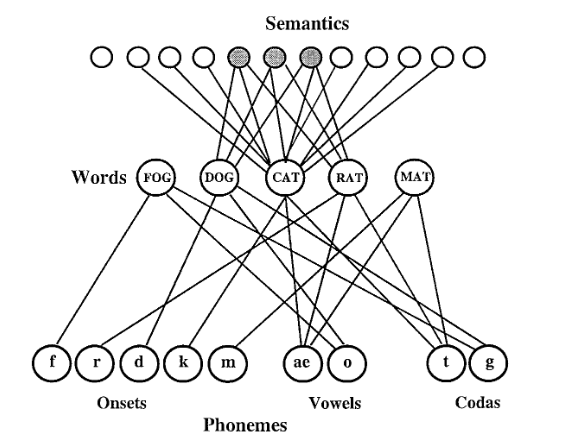
<br>
<br>
The validity of SP model parameter estimates is supported by behavioral and neuroimaging evidence. For example, Schwartz, Dell, Martin, Gahl, and Sobel found that the distributions of picture naming response types from 94 PWA on the PNT were similar to those predicted by the SP model. In a subsequent voxel-based lesion parameter mapping study, Dell and colleagues (2013) found associations between lesion sites and s- and p-weights that were consistent with findings from prevailing dual-stream models of language processing (Hickok & Poeppel, 2004, 2007; Saur et al., 2008). The supramarginal gyrus, post-central gyrus, pre-central gyrus, and insula shared a relationship with p-weight and lesions to the anterior temporal lobe, frontal lobe, parietal-temporal junction, and angular gyrus were associated with s-weights.
<br>
<br>
Although the SP model has gained considerable support from neuroimaging and behavioral studies, it has three notable shortcomings. First, it includes arbitrary semantic representations, and is therefore unable to account for real semantic relationships between words. Second, it was built to model the proportion of error types on the 175 item Philadelphia Naming Test (PNT; Roach et al., 1996), and is therefore unable to make item level predictions. Furthermore, given that the SP model was built in conjunction with the development of the PNT, it is unable to make inference on how individuals may respond to picturable nouns outside the PNT. Third, the model was not explicitly built upon the neurobiology of language; instead, the neurological correlates of its parameters were found well after the model was established. 
<br>
<br>
The purpose of this Jupyter notebook is to introduce my preliminary work in addressing the first and second limitations as addressed above by implementing a linear artifical neural network (ANN) with meaningful semantic input and an increased number of words by a factor of roughly 10. Here, I capatalize on a pretrained neural network, word2vec, to extract word embeddings for XXXXX number of words.  Then, use the word embeddings as input to the model, and phonogical sequences as the output.  The intended structure of the model is identical to that of Foygel and Dell's (2000) SP model. 

### Preliminary code

In [4]:
import gensim
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [5]:
#Load data
import pandas as pd
from pandas import DataFrame
#words = pd.read_csv('wordlist.csv')
words = pd.read_csv('wordlistAnomia.csv')
#words.columns = ['Number', 'Word']

df = DataFrame(words, columns= ['Word'])
df_list = df.values.tolist()

#### Grab word embeddings from gloves wiki gigaword (next line of code takes a few minutes to run)

In [3]:
#Method 1: Get word embeddings for all available words from Wikigigaworld.
import gensim.downloader as api
# Download dataset
glove_model300 = api.load('glove-wiki-gigaword-300')
#create np array called word_array
word_array = np.empty((0, 300))
not_found = []
for idx, row in words.iterrows():
    try:
        result = glove_model300.word_vec(row[0])
        word_array = np.append(word_array, [result], axis = 0)
    except KeyError:
        not_found.append(row[0]) 

In [4]:
#Method 2: Create similarity matrix
from pandas import DataFrame
words = pd.read_csv('wordlist.csv')
#words.columns = ['Number', 'Word']
words

df = DataFrame(words, columns= ['Word'])
df_list = df.values.tolist()
#print(df_list)
#print(df)

from itertools import combinations
#convert pandas df to list
word_list = words['Word'].tolist()
#create every combination of items in the word list, the two is the number of comparisons
comb = list(combinations(word_list, 2))
network = []
for pair in comb: 
    temp = []
    temp.append(pair[0])
    temp.append(pair[1])
    try:
        temp.append(glove_model300.similarity(pair[0], pair[1]))
    except:
        temp.append(-999) # Term not found

    network.append(temp)
#create similarity matrix    
df_similarity = pd.DataFrame(network, columns=['origin','target','similarity'])
df_similarity.head()

,origin,target,similarity
0,ant,bear,0.110003
1,ant,beaver,0.216053
2,ant,bee,0.359626
3,ant,bird,0.239848
4,ant,bug,0.335570



### Download dataset
glove_model300 = api.load('glove-wiki-gigaword-300')

In [6]:
from pandas import DataFrame
from itertools import combinations
from torch.autograd import Variable
import torch.utils.data as data

In [7]:
#load words with transcriptions
phon = pd.read_csv('wordWtranscription.csv')
#phon = pd.read_csv('wordWtranscriptionAnomia2.csv')
phon.head()

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ANT,AE,N,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BEAR,B,EH,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BEAVER,B,IY,V,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BEE,B,IY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BIRD,B,ER,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#create single vector based on the Word column 
X = phon['word']
X.head()

0       ANT
1      BEAR
2    BEAVER
3       BEE
4      BIRD
Name: word, dtype: object

In [9]:
#replace NaN with nothing
phon.fillna('', inplace = True)
phon.head()

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ANT,AE,N,T,,,,,,,,,,,
1,BEAR,B,EH,R,,,,,,,,,,,
2,BEAVER,B,IY,V,ER,,,,,,,,,,
3,BEE,B,IY,,,,,,,,,,,,
4,BIRD,B,ER,D,,,,,,,,,,,


In [10]:
#word_array = np.empty((0, 300))
for idx, row in enumerate(X):
    try:
        word_array = np.empty((0, 300))
        result = glove_model300.word_vec(row)
        word_array = np.append(word_array, [result], axis = 0)
        X[idx] = word_array
    except:
         X[idx] = 'None'

In [11]:
#create new y variable with just the arpabet characters for each word
y = phon.drop(['word'], axis = 1)
y.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,AE,N,T,,,,,,,,,,,
1,B,EH,R,,,,,,,,,,,
2,B,IY,V,ER,,,,,,,,,,
3,B,IY,,,,,,,,,,,,
4,B,ER,D,,,,,,,,,,,


In [12]:
#create single vector based on the Word column 
X = phon['word']
X.head()

0    None
1    None
2    None
3    None
4    None
Name: word, dtype: object

In [13]:
#create new y variable with just the arpabet characters for each word
y = phon.drop(['word'], axis = 1)
y.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,AE,N,T,,,,,,,,,,,
1,B,EH,R,,,,,,,,,,,
2,B,IY,V,ER,,,,,,,,,,
3,B,IY,,,,,,,,,,,,
4,B,ER,D,,,,,,,,,,,


In [14]:
replace_phons = {'':0,
'AA' :1,

'AE' :2,

'AH' :3,

'AO' :4,

'AW' :5,

'AY' :6,

'B' :7,

'CH' :8,

'D' :9,

'DH' :10,

'EH' :11,

'ER' :12,

'EY' :13,

'F' :14,

'G' :15,

'HH' :16,

'IH' :17,

'IY' :18,

'JH' :19,

'K' :20,

'L' :21,

'M' :22,

'N' :23,

'NG' :24,

'OW' :25,

'OY' :26,

'P' :27,

'R' :28,

'S' :29,

'SH' :30,

'T' :31,

'TH' :32,

'UH' :33,

'UW' :34,

'V' :35,

'W' :36,

'Y' :37,

'Z' :38,

'ZH' :39}

In [15]:
y.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,AE,N,T,,,,,,,,,,,
1,B,EH,R,,,,,,,,,,,
2,B,IY,V,ER,,,,,,,,,,
3,B,IY,,,,,,,,,,,,
4,B,ER,D,,,,,,,,,,,


In [16]:
#sorted_data
#add column "word_emd" to y that is equal to the target list X
y['Word_emd'] = X
#do not allow missing values
y = y[y.Word_emd != 'None']
#make sure X is now equal to the new y
X = y['Word_emd']

In [17]:
X

Series([], Name: Word_emd, dtype: object)

In [18]:
#replace arpabet letters with their assosciated numerical values
for col in y.columns:
    if col != 'Word':
        y[col] = y[col].map(replace_phons)

In [19]:
y

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Word_emd


In [20]:
#make copy of phon to try this step again
phon_dup = phon.copy()
phon_dup.head()

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,None,AE,N,T,,,,,,,,,,,
1,None,B,EH,R,,,,,,,,,,,
2,None,B,IY,V,ER,,,,,,,,,,
3,None,B,IY,,,,,,,,,,,,
4,None,B,ER,D,,,,,,,,,,,


In [21]:
for col in phon_dup.columns:
    #y[col] = y.replace({col: replace_phons}) 
    if col != 'Word':
        phon_dup[col] = phon_dup[col].map(replace_phons)

In [22]:
#success
phon_dup.head()

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,2,23,31,0,0,0,0,0,0,0,0,0,0,0
1,NaN,7,11,28,0,0,0,0,0,0,0,0,0,0,0
2,NaN,7,18,35,12,0,0,0,0,0,0,0,0,0,0
3,NaN,7,18,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,7,12,9,0,0,0,0,0,0,0,0,0,0,0


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ValueError: With n_samples=0, test_size=0.1 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#### Linear Model 

In [48]:
class LinearModel(nn.Module):
    def __init__(self,
                 linear_size=300,
                 p_dropout=0.5):
        super(LinearModel, self).__init__()

        self.linear_size = linear_size
        self.p_dropout = p_dropout

        #Input Size
        self.input_size =  300
        #Output Size
        self.output_size = 14

        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x):
        # pre-processing
        y = self.w1(x)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.w2(y)

        return y

In [49]:
model = LinearModel()
model

LinearModel(
  (w1): Linear(in_features=300, out_features=300, bias=True)
  (w2): Linear(in_features=300, out_features=14, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [51]:
criterion = nn.MSELoss()

In [52]:
X_train

244        WITCH
1514       BEARD
730     MACAROON
1385    BRACELET
1278        LEAF
          ...   
1130     SPINACH
1294        SOOT
860         JEEP
1459       HOUSE
1126       ELBOW
Name: Word_emd, Length: 1398, dtype: object